In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
from sqlalchemy import text

sn.set_context("notebook")
sn.set_style("ticks", {"axes.grid": True})

In [2]:
# Connect to db
engine = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# Annual runoff bar chart

See e-mail from Øyvind Kaste received 08.09.2023 at 12.37.

In [3]:
# Year of interest
year = 2022

In [4]:
# Read new site groupings (for 2017 to 2020)
in_xlsx = r"../../../data/RID_Sites_List_2017-2020.xlsx"
rid_20_df = pd.read_excel(in_xlsx, sheet_name="RID_20")
rid_20_df = rid_20_df.query("station_id != 29848")  # TROEMÅL replaced by TROEMÅL2
rid_20_df

,station_id,station_code,station_name,old_rid_group,new_rid_group,ospar_region,station_type,nve_vassdrag_nr,lat,lon,utm_north,utm_east,utm_zone
0,30019,AAGEVEG,Vegårdselva,rid_108,rid_20,SKAGERAK,R,018.A322,58.669996,8.980983,6503307.00,498897.00,32
1,29612,BUSEDRA,Drammenselva,rid_11,rid_20,SKAGERAK,R,012.A3,59.753995,10.008990,6624446.00,556695.00,32
2,29779,FINEALT,Altaelva,rid_11,rid_20,LOFOTEN-BARENTS SEA,R,212.A0,69.900992,23.286977,7759686.00,586586.00,34
3,29819,FINEPAS,Pasvikelva,rid_36,rid_20,LOFOTEN-BARENTS SEA,R,246.A5,69.500996,30.115996,7712884.00,387322.00,36
4,29820,FINETAN,Tanaelva,rid_36,rid_20,LOFOTEN-BARENTS SEA,R,234.B41,70.229993,28.173988,7791949.00,544316.00,35
5,29821,HOREVOS,Vosso (Bolstadelvi),rid_11,rid_20,NORTH SEA,R,062.C1,60.647000,6.112000,6726970.00,342124.00,32
6,29822,MROEDRI,Driva,rid_36,rid_20,NORWEGIAN SEA2,R,109.A0,62.668999,8.570990,6948784.00,478024.00,32
7,29782,NOREVEF,Vefsna,rid_11,rid_20,NORWEGIAN SEA2,R,151.A4,65.749000,13.239000,7293064.00,419297.00,33
8,36225,OSLEALN,Alna,rid_11,rid_20,SKAGERAK,R,006.2A0,59.905091,10.791359,6642144.00,600213.00,32
9,29832,ROGEBJE,Bjerkreimselva,rid_36,rid_20,NORTH SEA,R,027.A21,58.478994,5.994986,6485932.00,674624.00,31


In [5]:
# Calculate annual runoff for previous 5 years
df_list = []
for idx, row in rid_20_df.iterrows():
    stn_id = row["station_id"]
    stn_name = row["station_name"].split(" ")[0]

    # Get catchment area
    sql = text("SELECT catchment_area FROM resa2.stations WHERE station_id = :stn_id")
    area_km2 = pd.read_sql(sql, engine, params={"stn_id": stn_id})[
        "catchment_area"
    ].iloc[0]

    # Get flow for previous 5 years
    q_df = nivapy.da.extract_resa_discharge(
        stn_id, f"{year-4}-01-01", f"{year}-12-31", engine
    )

    # Calculate runoff in mm/yr
    ro_df = (
        1000
        * (q_df * 24 * 60 * 60).resample("A").sum(numeric_only=True)
        / (area_km2 * 1e6)
    )
    ro_df.rename({"flow_m3/s": "Runoff (mm/yr)"}, axis="columns", inplace=True)
    ro_df["Name"] = stn_name
    ro_df["Year"] = ro_df.index.year
    ro_df.reset_index(inplace=True, drop=True)

    # Separate this year's data from 5-year data
    an_df = ro_df.query("Year == @year").copy()
    ro_df["Period"] = "5-year mean"
    an_df["Period"] = f"{year}"
    df = pd.concat([ro_df, an_df], axis="rows")

    df_list.append(df)

df = pd.concat(df_list, axis="rows")
df = df[["Name", "Period", "Year", "Runoff (mm/yr)"]]

# Save
csv_path = f"/home/jovyan/shared/common/elveovervakingsprogrammet/results/measured_loads/rid20_annual_runoff_{year}.csv"
df.to_csv(csv_path, index=False)

df.head()

,Name,Period,Year,Runoff (mm/yr)
0,Vegårdselva,5-year mean,2018,838.362216
1,Vegårdselva,5-year mean,2019,1186.921875
2,Vegårdselva,5-year mean,2020,1072.427241
3,Vegårdselva,5-year mean,2021,765.633259
4,Vegårdselva,5-year mean,2022,843.250521


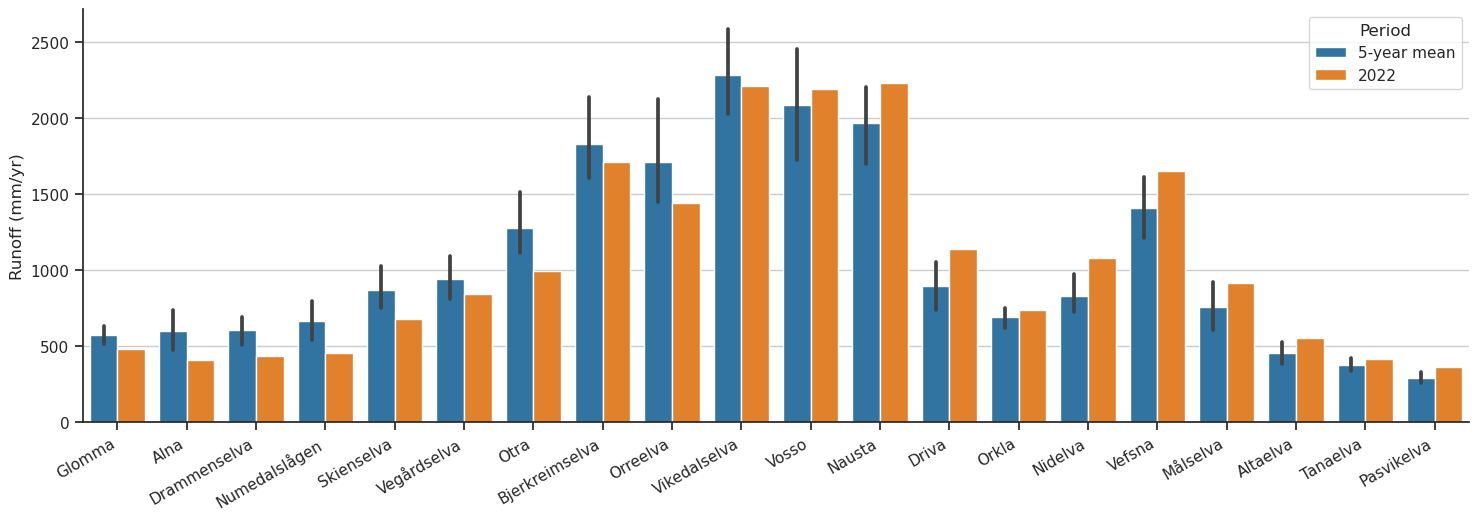

In [6]:
# Order clockwise from SE
order = [
    "Glomma",
    "Alna",
    "Drammenselva",
    "Numedalslågen",
    "Skienselva",
    "Vegårdselva",
    "Otra",
    "Bjerkreimselva",
    "Orreelva",
    "Vikedalselva",
    "Vosso",
    "Nausta",
    "Driva",
    "Orkla",
    "Nidelva",
    "Vefsna",
    "Målselva",
    "Altaelva",
    "Tanaelva",
    "Pasvikelva",
]

g = sn.catplot(
    data=df,
    x="Name",
    y="Runoff (mm/yr)",
    hue="Period",
    order=order,
    kind="bar",
    aspect=3,
    legend_out=False,
)
g.set_xticklabels(rotation=30, ha="right")
plt.xlabel("")

png_path = f"/home/jovyan/shared/common/elveovervakingsprogrammet/results/measured_loads/rid20_annual_runoff_{year}.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")